In [1]:
import numpy as np
from numpy.random import default_rng
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns
from typing import NamedTuple

from fct import PVTrainDataSet, PVTestDataSet

### Data Generation (Test & Eval Set)

In [2]:
def psi(t: np.ndarray) -> np.ndarray:
    """
    g fct in Kompa
    """
    return 2 * ((t - 5) ** 4 / 600 + np.exp(-4 * (t - 5) ** 2) + t / 10 - 2)

def cal_outcome(A, W, U, params):
    """
    Y (no noise)
    """
    beta_a, beta_w, pi_w  = params
    return np.clip(np.exp(beta_a*A + beta_w* W), None, 5.0) * A + pi_w * psi(U)

def generatate_data(n_sample: int, params, rng, Z_noise: float = 1, W_noise: float = 1, Y_noise: float = 1):
    U = rng.uniform(0, 10, n_sample)
    Z1 = 2 * np.sin(U * np.pi * 2 / 10) + rng.normal(0, Z_noise, n_sample)
    Z2 = 2 * np.cos(U * np.pi * 2 / 10) + rng.normal(0, Z_noise, n_sample)
    A = 35 + (Z1 + 3) * psi(U) + Z2 + rng.normal(0, 1.0, n_sample)
    W = 7 * psi(U) + 45 + rng.normal(0, W_noise, n_sample)
    Y = (cal_outcome(A, W, U, params) + rng.normal(0, Y_noise, n_sample)).astype(float)
    return U, Z1, Z1, A, W, Y

def generate_train_data(n_sample: int, params,
                        Z_noise: float = 1, W_noise: float = 1, Y_noise: float = 1, seed=42):
    rng = default_rng(seed=seed)
    U, Z1, Z2, A, W, Y = generatate_data(n_sample, params, rng, Z_noise, W_noise, Y_noise)
    return PVTrainDataSet(treatment=A,
                          treatment_proxy=np.c_[Z1, Z2],
                          outcome_proxy=W,
                          outcome=Y
                         )

def cal_true_effect(a: float, params, 
                    W_noise: float = 1, n_MC: int = 10000):
    """
    To estimate true effect
    Always same seed
    """
    rng = default_rng(seed=42)
    U = rng.uniform(0, 10.0, n_MC)
    W = 7 * psi(U) + 45 + rng.normal(0, W_noise, n_MC)
    Y = cal_outcome(a, W, U, params)
    return np.mean(Y)


def generate_eval_data(params, a_start: float = -2, a_end: float = 2, n_steps: int = 100):
    a_steps = np.linspace(a_start, a_end, n_steps)
    struc = np.array([cal_true_effect(a, params) for a in a_steps])
    return PVTestDataSet(treatment=a_steps,
                         structural=struc,
                         )

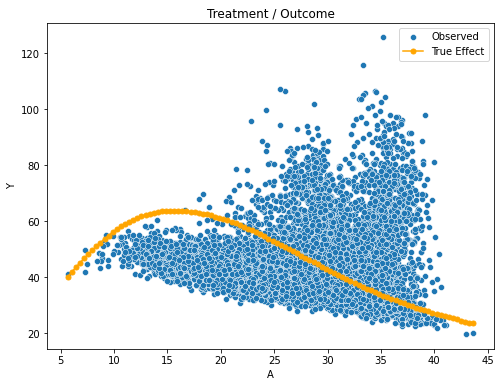

In [3]:
# Sample Parameters
n_sample = 10000
random_seed = 50
n_MC = 10000

# True Parameters
beta_a_true = -0.1
beta_w_true = 0.1
pi_w_true = -5
params_true = np.array([beta_a_true, beta_w_true, pi_w_true])

# Noise Parameters
Z_noise = 1
W_noise = 1
Y_noise = 1

# train
train_data = generate_train_data(n_sample=n_sample, params=params_true, 
                        Z_noise = Z_noise, W_noise = W_noise, Y_noise = Y_noise, seed=random_seed)
# val
val_data = generate_train_data(n_sample=n_sample, params=params_true, 
                        Z_noise = Z_noise, W_noise = W_noise, Y_noise = Y_noise, seed=random_seed+1)

A_train = train_data.treatment
Y_train = train_data.outcome

# Evaluate at more steps
eval_data = generate_eval_data(params=params_true, a_start= min(A_train), a_end =max(A_train), n_steps = 100)

a_eval = eval_data.treatment
y_true = eval_data.structural

plt.figure(figsize=(8, 6))
sns.scatterplot(x=A_train, y=Y_train, label='Observed')
plt.plot(a_eval, y_true, color='orange', marker='o', label="True Effect", markersize=5)
plt.title('Treatment / Outcome')
plt.xlabel('A')
plt.ylabel('Y')
plt.legend()
plt.show()

### GMM

In [4]:
def model(A_in, W_in, params): 
    """
    Y with U removed
    """
    beta_a, beta_w, pi_w  = params
    A = np.copy(A_in)
    W = np.copy(W_in)

    return np.clip(np.exp(beta_a*A + beta_w* W), None, 5.0) * A + pi_w / 7 * W - pi_w * 45/7

def g_vec(y, var_model, var_inst, params):
    """
    g vector for GMM
    y: outcome
    var_model: A, W
    var_inst: A, Z1, Z2
    """
    error = y - model(var_model[:, 0], var_model[:, 1], params)
    g = np.mean(var_inst * error.reshape(-1, 1), axis = 0).reshape(-1, 1)
    return g

In [5]:
def gradient_beta_a(A_in, W_in, params):
    beta_a, beta_w, pi_w  = params
    A = np.copy(A_in)
    W = np.copy(W_in)
    
    condition = np.exp(beta_a*A + beta_w*W) <= 5
    grad_beta_a = np.where(condition, A**2 * np.exp(A*beta_a + W*beta_w), 0)
    return grad_beta_a

def gradient_beta_w(A_in, W_in, params):
    beta_a, beta_w, pi_w  = params
    A = np.copy(A_in)
    W = np.copy(W_in)
    
    condition = np.exp(beta_a*A + beta_w*W) <= 5
    grad_beta_w = np.where(condition, A * W * np.exp(A*beta_a + W*beta_w), 0)
    return grad_beta_w

def gradient_pi_w(A_in, W_in, params):
    beta_a, beta_w, pi_w  = params
    W = np.copy(W_in)

    grad_pi_w = W/7 - 45/7
    return grad_pi_w


In [6]:
def g_grad(g_vec, y, var_model, var_inst, params):
    # parameter gradients
    grad_beta_a = gradient_beta_a(var_model[:, 0], var_model[:, 1], params)
    grad_beta_w = gradient_beta_w(var_model[:, 0], var_model[:, 1], params)
    grad_pi_w = gradient_pi_w(var_model[:, 0], var_model[:, 1], params)
    grad_param = np.array([grad_beta_a, grad_beta_w, grad_pi_w]).T
    
    # loss fct gradient
    error = y - model(var_model[:, 0], var_model[:, 1], params)
    
    grad_loss = np.sum(-2*error.reshape(-1, 1)*(var_inst**2), axis=1).reshape(-1, 1)
    
    # final gradient
    g_grad = np.mean(grad_loss*grad_param, axis=0)

    return g_grad

In [7]:
def criterion(params, *var): 
    """
    c(params) = g.T(params) W g(params)
    want to min c
    """
    y, var_model, var_inst, W_hat = var
    g = g_vec(y, var_model, var_inst, params)
    crit_val = np.dot(np.dot(g.T, W_hat), g) 
    grad = g_grad(g, y, var_model, var_inst, params)
    
    return crit_val, grad

### GMM Initialization & Minimization

#### Highly dependend on starting values due to Clip (no gradient above a certain point and then minimization problem is ill definied

In [8]:
beta_a_init = 0
beta_w_init = 0
pi_w_init = 0
params_init = np.array([beta_a_init, beta_w_init, pi_w_init])
W_hat = np.eye(3)

a_gmm = train_data.treatment
y_gmm = train_data.outcome
w_gmm = train_data.outcome_proxy
z_gmm = train_data.treatment_proxy
var_model = np.c_[a_gmm, w_gmm]
var_inst = np.c_[a_gmm, z_gmm]
gmm_args = (y_gmm, var_model, var_inst, W_hat)
print("Initial Results:", criterion(params_init, *gmm_args))

#results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-6, options  = {"maxiter":100000, "disp":True})
results = opt.minimize(criterion, params_init, args=(gmm_args), jac = True,#method='BFGS',
                       tol=1e-6, options  = {"maxiter":100000, "disp":True})
results
# [-0.09538106,  0.09384966, -5.82105308]
# [-0.09988131,  0.10000621, -4.9514218 ]

Initial Results: (array([[162786.51626628]]), array([-17453044.69566469, -20641229.98648771,     37018.30870285]))
         Current function value: 0.000582
         Iterations: 26
         Function evaluations: 157
         Gradient evaluations: 145


      fun: 0.0005816659105056755
 hess_inv: array([[ 5.23442337e-08, -4.35499452e-08,  2.65749400e-06],
       [-4.35499452e-08,  3.68467309e-08, -2.01293592e-06],
       [ 2.65749400e-06, -2.01293591e-06,  3.71686152e-04]])
      jac: array([ 3.29097465e+04,  2.59846119e+04, -2.88060078e+01])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 157
      nit: 26
     njev: 145
   status: 2
  success: False
        x: array([-0.09988131,  0.10000621, -4.9514218 ])

### Average over 20 seeds and with different sample sizes

In [27]:
seeds = [5305, 7165, 8789, 1552, 5635, 8970, 6842, 7561, 1418, 7902, 
         9086, 1384, 3412, 1810, 7375, 4600, 6932, 3199, 4768, 69]
results = []
n_sample_seeds = 1000
for r_seed in seeds:
    train_data_seeds = generate_train_data(n_sample=n_sample_seeds, params=params_true, 
                            Z_noise = Z_noise, W_noise = W_noise, Y_noise = Y_noise, seed=r_seed)

    a_gmm = train_data_seeds.treatment
    y_gmm = train_data_seeds.outcome
    w_gmm = train_data_seeds.outcome_proxy
    z_gmm = train_data_seeds.treatment_proxy
    var_model = np.c_[a_gmm, w_gmm]
    var_inst = np.c_[a_gmm, z_gmm]
    gmm_args = (y_gmm, var_model, var_inst, W_hat)
    
    
    res = opt.minimize(criterion, params_init, args=(gmm_args), jac = True,
                           tol=1e-6, options  = {"maxiter":100000, "disp":False})
    results.append(res.x)

final_results = np.mean(np.array(results), axis=0)
print("True Params", params_true)
print("Final Results", final_results)
# [-0.10002227,  0.10012671, -4.95115772]
# 1000: [-0.09987713  0.10000961 -4.94406191]
# 1000 sample size seems to be enough

True Params [-0.1  0.1 -5. ]
Final Results [-0.09987713  0.10000961 -4.94406191]


### Create Predcition Set

In [28]:
# params_pred = results.x
# params_pred = params_true # sanity check
params_pred = final_results


a_temp = eval_data.treatment.reshape(-1, 1)
w_temp = val_data.outcome_proxy.reshape(-1, 1)
n_test_samples = a_temp.shape[0]
n_val_samples = w_temp.shape[0]
temp_A = np.broadcast_to(a_temp,(a_temp.shape[0], n_val_samples))
temp_W = np.broadcast_to(w_temp,(w_temp.shape[0], n_test_samples))
AW_test = np.stack((temp_A, temp_W.T), axis=-1)
# obtain predicted values
y_pred = [np.mean(model(AW_test[i, :, 0], AW_test[i, :, 1], params=params_pred)) for i in range(AW_test.shape[0])]

### Plot Results

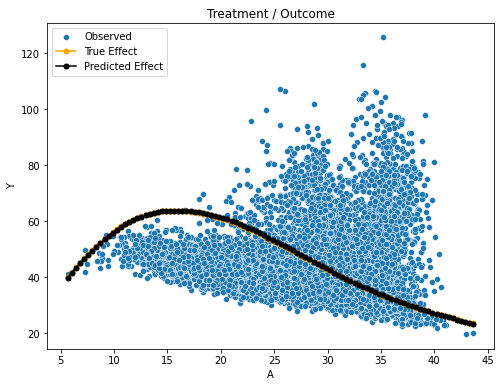

In [29]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=A_train, y=Y_train, label='Observed')
plt.plot(a_eval, y_true, color='orange', marker='o', label="True Effect", markersize=5)
plt.plot(a_eval, y_pred, color='black', marker='o', label="Predicted Effect", markersize=5)
plt.title('Treatment / Outcome')
plt.xlabel('A')
plt.ylabel('Y')
plt.legend()
plt.show()